In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [2]:
from collections import namedtuple

Y = namedtuple('Y', ['mu', 'std', 'c_l', 'c_u'])
Keys = ['loss', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape']

In [3]:
import glob

In [4]:
dataset = 'sm1_2010.csv'

In [5]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')

In [6]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')[0]
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')[0]
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')[0]
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')[0]
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')[0]

In [7]:
def get_ci(x, z=1.96):
    if x.ndim == 2:
        n = x.shape[1]
        mu = x.mean(axis=1)
        std = x.std(axis=1)
    else:
        n = x.shape[0]
        mu = x.mean()
        std = x.std()
        
    c_l, c_u = (mu - z * std/np.sqrt(n), mu + z * std/np.sqrt(n))
    return mu, std, c_l, c_u

In [8]:
def get_train_results(path, key='mae', z=1.96):
    return Y(*get_ci(pd.concat([pd.read_csv(x+'/train/results.csv')[key] for x in path], axis=1), z=z))

In [9]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')
df_seq2seq = pd.read_csv(seq2seq + '/train/results.csv')

In [10]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

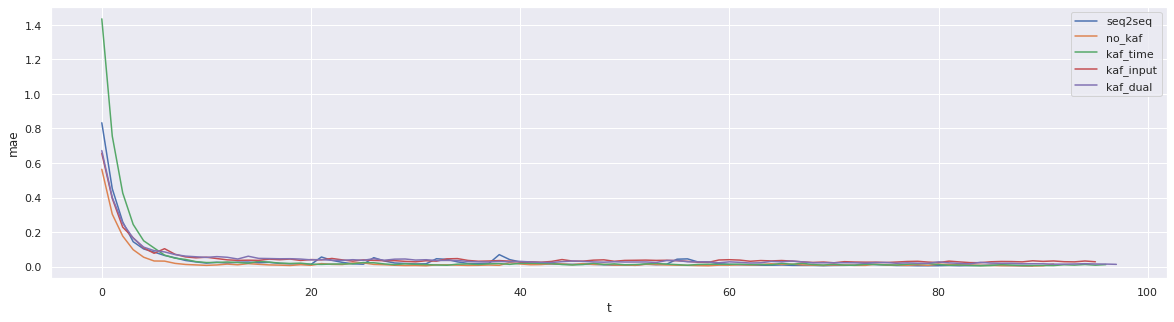

In [11]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

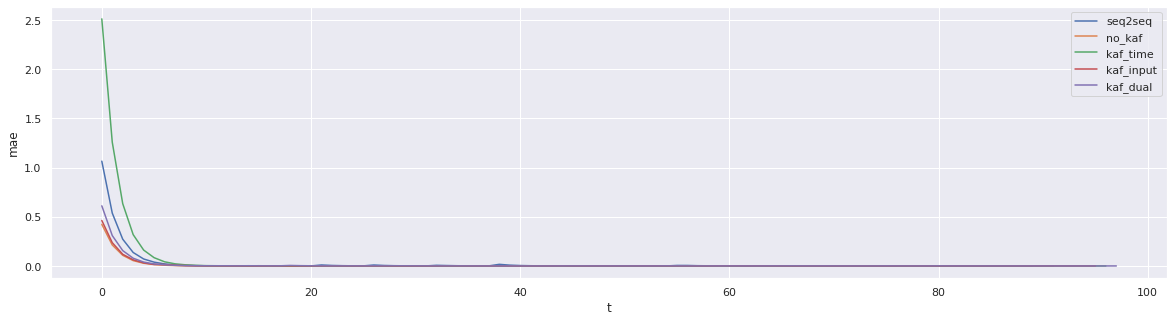

In [12]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.mse.values))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [13]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [14]:
# no reg
rows = ['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_seq2seq.mean(axis=0),
                   df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.029602,0.001959,1.293022,0.013521,0.027644,0.046668,0.027644,10.634804
no_kaf,0.017789,0.000000,3.025923,0.004931,0.017789,0.031826,0.017789,6.332915
kaf_time,0.032224,0.001938,4.320840,0.026594,0.030287,0.044521,0.030287,8.887047
kaf_input,0.043279,0.016552,6.001500,0.005772,0.026727,0.048629,0.026727,11.514507
kaf_dual,0.039909,0.017157,5.219729,0.006975,0.022752,0.040246,0.022752,9.301606


In [15]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.009338,0.000119,0.073782,0.011821,0.009312,0.015764,0.009312,2.157604
no_kaf,0.006070,0.000000,0.184533,0.004592,0.006070,0.014471,0.006070,1.205850
kaf_time,0.014692,0.000468,0.264939,0.025875,0.014420,0.018062,0.014420,1.347528
kaf_input,0.006719,0.000677,0.354164,0.004805,0.006329,0.014937,0.006329,1.291980
kaf_dual,0.006803,0.001134,0.298813,0.006228,0.006075,0.012293,0.006075,1.178386


In [16]:
table.index

Index(['loss', 'reg', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape'], dtype='object')

In [17]:
header = table.index.tolist()

In [18]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', header=None)
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))
df_no_kaf.columns = header

In [19]:
df_seq2seq = pd.read_csv(seq2seq+ '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

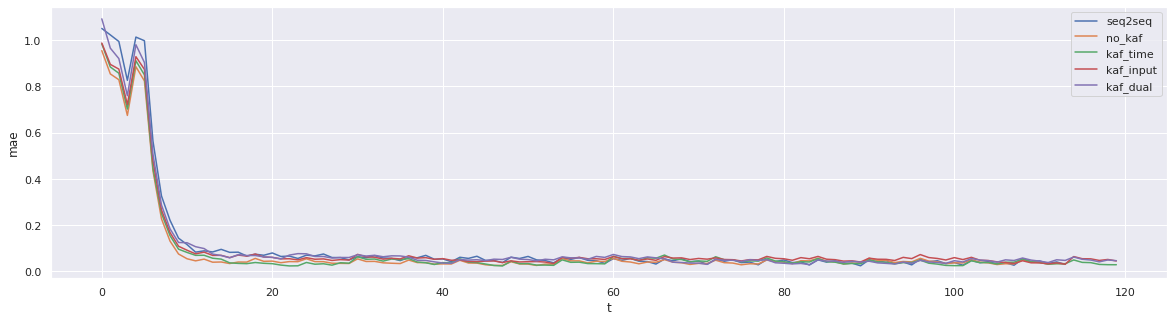

In [20]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [21]:
table = pd.concat([
                    df_seq2seq.mean(axis=0),
                    df_no_kaf.mean(axis=0), 
                    df_kaf_time.mean(axis=0), 
                    df_kaf_input.mean(axis=0), 
                    df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

In [22]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.100341,0.002140,1.485268,0.094603,0.098201,0.147991,0.098201,26.549324
no_kaf,0.079669,0.000000,3.589149,0.060132,0.079669,0.116172,0.079669,14.714584
kaf_time,0.080738,0.002456,5.397016,0.057103,0.078282,0.116002,0.078282,16.120587
kaf_input,0.093350,0.017257,5.510704,0.057833,0.076093,0.115460,0.076093,15.886424
kaf_dual,0.095420,0.018809,5.137060,0.060619,0.076611,0.112450,0.076611,15.053209


In [23]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.019847,0.000091,0.059666,0.030560,0.019799,0.029899,0.019799,3.149252
no_kaf,0.016814,0.000000,0.142537,0.022783,0.016814,0.028839,0.016814,2.053043
kaf_time,0.016505,0.000535,0.226442,0.021724,0.016041,0.027522,0.016041,1.997606
kaf_input,0.016605,0.000721,0.260076,0.021711,0.016028,0.027162,0.016028,1.992460
kaf_dual,0.017580,0.001294,0.223214,0.022756,0.016505,0.027480,0.016505,2.414972


In [24]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    paths
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [25]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

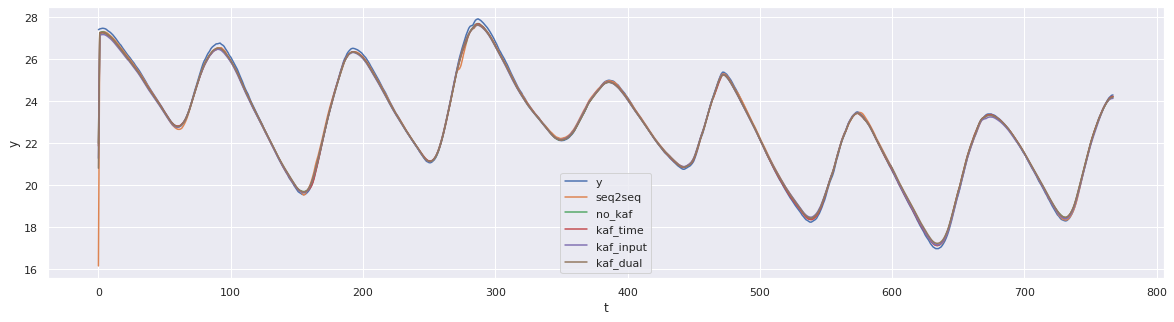

In [26]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
            'seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [27]:
from ntsa.utils.misc import regr_metrics

In [28]:
y = df_no_kaf.y.values
y_seq2seq = df_seq2seq.y_hat.values
y_no_kaf = df_no_kaf.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

In [29]:
metrics = [
list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [37]:
pd.DataFrame(np.array(metrics), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,0.177484,0.101945,0.004506,0.002238,0.972639,0.474955
no_kaf,0.050199,0.095596,0.004162,0.002099,0.992261,0.420739
time,0.050309,0.086753,0.003737,0.001905,0.992244,0.378472
input,0.065557,0.111763,0.004822,0.002455,0.989894,0.488328
dual,0.070528,0.103955,0.004605,0.002282,0.989127,0.466925


In [34]:
import collections
def get_test_metrics(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    data  = {}
    for p,idx in zip(paths, idxs):
        data[idx] = pd.read_csv(p, index_col=0)
    data = collections.OrderedDict(sorted(data.items()))
    m = {}
    for k, v in data.items():
        m[k] = list(regr_metrics(v.y.values,v.y_hat.values).values())
    return np.array(list(m.values()))

In [35]:
table = [get_test_metrics(seq2seq).mean(axis=0),
get_test_metrics(no_kaf).mean(axis=0),
get_test_metrics(kaf_time).mean(axis=0),
get_test_metrics(kaf_input).mean(axis=0),
get_test_metrics(kaf_dual).mean(axis=0)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,0.602641,0.247851,0.010879,0.005442,0.907097,1.101422
no_kaf,0.383054,0.201079,0.008851,0.004419,0.940948,0.887867
time,0.363758,0.197577,0.008691,0.004341,0.943923,0.871399
input,0.368405,0.192053,0.008469,0.004220,0.943207,0.849592
dual,0.386155,0.193362,0.008584,0.004248,0.940470,0.862072


In [36]:
# std/n_checkpoints
table = [get_test_metrics(seq2seq).std(axis=0)/np.sqrt(20),
get_test_metrics(no_kaf).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_time).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_input).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_dual).std(axis=0)/np.sqrt(20)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,0.435686,0.116424,0.005131,0.002557,0.067165,0.510363
no_kaf,0.317976,0.097880,0.004326,0.002153,0.049019,0.431347
time,0.311645,0.095809,0.004235,0.002107,0.048043,0.422334
input,0.311801,0.095910,0.004238,0.002109,0.048067,0.422435
dual,0.323468,0.098370,0.004343,0.002163,0.049866,0.433576
